In [21]:
from roboflow import Roboflow
rf = Roboflow(api_key="MlhapacbzjvYZYQMuv5X")
project = rf.workspace("happiest-minds").project("yolo_products-v7cqv")
dataset = project.version(3).download("yolov8")
model = project.version(3).model

# infer on a local image
results = model.predict(r'C:\Users\kaushal.i.g\Downloads\train_images\train\images\2019_08_02_04_08_39_test7_jpg.rf.b7d46f8c68a70935453ffc70839a1fd4.jpg', confidence=0, overlap=0).json()
print(results)

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.134 is required but found version=8.0.191, to fix: `pip install ultralytics==8.0.134`



Extracting Dataset Version Zip to YOLO_products-3 in yolov8:: 100%|███████████████████| 42/42 [00:00<00:00, 506.61it/s]


{'predictions': [{'x': 122.0, 'y': 384.5, 'width': 68.0, 'height': 115.0, 'confidence': 0.9024977684020996, 'class': 'roundup', 'class_id': 53, 'image_path': 'C:\\Users\\kaushal.i.g\\Downloads\\train_images\\train\\images\\2019_08_02_04_08_39_test7_jpg.rf.b7d46f8c68a70935453ffc70839a1fd4.jpg', 'prediction_type': 'ObjectDetectionModel'}, {'x': 422.0, 'y': 383.0, 'width': 86.0, 'height': 124.0, 'confidence': 0.874916672706604, 'class': 'Weedbgone', 'class_id': 2, 'image_path': 'C:\\Users\\kaushal.i.g\\Downloads\\train_images\\train\\images\\2019_08_02_04_08_39_test7_jpg.rf.b7d46f8c68a70935453ffc70839a1fd4.jpg', 'prediction_type': 'ObjectDetectionModel'}, {'x': 281.5, 'y': 387.0, 'width': 77.0, 'height': 120.0, 'confidence': 0.853508710861206, 'class': 'roundup', 'class_id': 53, 'image_path': 'C:\\Users\\kaushal.i.g\\Downloads\\train_images\\train\\images\\2019_08_02_04_08_39_test7_jpg.rf.b7d46f8c68a70935453ffc70839a1fd4.jpg', 'prediction_type': 'ObjectDetectionModel'}, {'x': 581.0, 'y': 

In [4]:
import easyocr
reader = easyocr.Reader(['en'])

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


# Bounded Box

In [ ]:
import torch
import torchvision
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes
import cv2
import imagehash
import os
import matplotlib.pyplot as plt
import io
from PIL import Image
import easyocr
from difflib import SequenceMatcher

from roboflow import Roboflow
model = project.version(3).model

# infer on a local image
results = model.predict(r'C:\Users\kaushal.i.g\Downloads\train_images\train\images\2019_08_02_04_08_39_test7_jpg.rf.b7d46f8c68a70935453ffc70839a1fd4.jpg', confidence=0, overlap=0).json()
bbox = []
xywh_values = []
labels1 = []
img = read_image(r'C:\Users\kaushal.i.g\Downloads\train_images\train\images\2019_08_02_04_08_39_test7_jpg.rf.b7d46f8c68a70935453ffc70839a1fd4.jpg')

def calculate_hash_similarity(window):
    image1 = window
    image2 = Image.open(obj_url)

    
    hash1 = imagehash.average_hash(image1)
    hash2 = imagehash.average_hash(image2)

    
    similarity = 1.0 - (hash1 - hash2) / len(hash1.hash) ** 2

    return similarity

def calculate_rgb_similarity(window):
    image1 = window
    image2 = Image.open(obj_url)

    
    image1 = image1.resize(image2.size)

    
    image1 = image1.convert("RGB")
    image2 = image2.convert("RGB")

    
    histogram1 = image1.histogram()
    histogram2 = image2.histogram()

   
    similarity = sum(min(h1, h2) for h1, h2 in zip(histogram1, histogram2)) / float(sum(histogram1))
    return similarity



def yolobbox2bbox(x,y,w,h):
    box = []
    x1, y1 = x-w/2, y-h/2
    x2, y2 = x+w/2, y+h/2
    box.append(x1)
    box.append(y1)
    box.append(x2)
    box.append(y2)
    return box


for prediction in results['predictions']:
    x, y, w, h, name= prediction['x'], prediction['y'], prediction['width'], prediction['height'], prediction['class']
    xywh_values.append((x, y, width, height))
    labels1.append(name)
    x1 = int(x - w / 2)
    y1 = int(y - h / 2)
    x2 = int(x + w / 2)
    y2 = int(y + h / 2)
    cimg = img[y1:y2, x1:x2]
    hash = calculate_hash_similarity(cimg)
    rgb = calculate_rgb_similarity(cimg)
    total_images += 1
    
    img = Image.open(image_path)  
    image_gray = img.convert('L')   
    threshold = 128 
    image_binary = image_gray.point(lambda p: p > threshold and 255)

        
    image_bytes = io.BytesIO()
    image_binary.save(image_bytes, format='JPEG')
    image_bytes = image_bytes.getvalue()
    result = reader.readtext(image_bytes)
            
    text_detected = False
    target_text = "Roundup"
    for text in result:
        if SequenceMatcher(None, target_text, text[1]).ratio() >= 0.5:
            text_detected = True
            break

    if hash_sim >= 0.1 and rgb_sim >= 0.1 and text_detected:
        matched_images += 1
        
        
    
def coord(xywh_values):
    for xywh in xywh_values:
        x = xywh[0]
        y = xywh[1]
        w = xywh[2]
        h = xywh[3]
        bbox.append(yolobbox2bbox(x,y,w,h))

coord(xywh_values)
    
    
bbox = torch.tensor(bbox, dtype=torch.int)
print(bbox)
print(bbox.size())
img = draw_bounding_boxes(img, bbox, labels = labels1)
img = torchvision.transforms.ToPILImage()(img)
img.show()




## Sliding window

In [ ]:

import imagehash
import os
import matplotlib.pyplot as plt
import io
from PIL import Image
import easyocr
from difflib import SequenceMatcher

# Load the image
image_path = r'C:\Users\kaushal.i.g\Downloads\images\images\2019_11_22_07_19_02_ex2.jpg'
image = Image.open(image_path)

obj_url = r"C:\Users\kaushal.i.g\Downloads\objects\ref_roundup.jpg"
total_images = 0
matched_images = 0
def calculate_hash_similarity(window):
    image1 = window
    image2 = Image.open(obj_url)

    
    hash1 = imagehash.average_hash(image1)
    hash2 = imagehash.average_hash(image2)

    
    similarity = 1.0 - (hash1 - hash2) / len(hash1.hash) ** 2

    return similarity

def calculate_rgb_similarity(window):
    image1 = window
    image2 = Image.open(obj_url)

    
    image1 = image1.resize(image2.size)

    
    image1 = image1.convert("RGB")
    image2 = image2.convert("RGB")

    
    histogram1 = image1.histogram()
    histogram2 = image2.histogram()

   
    similarity = sum(min(h1, h2) for h1, h2 in zip(histogram1, histogram2)) / float(sum(histogram1))
    return similarity


# Get the image dimensions
width, height = image.size
window_size = (200, height)
stride = 100

# Iterate over the image pixels with a sliding window
for y in range(0, height - window_size[1] + 1, stride):
    for x in range(0, width - window_size[0] + 1, stride):
        # Extract the window region
        
        window = image.crop((x, y, x + window_size[0], y + window_size[1]))
        

        # Calculate the hash of the window region
        hash_sim = calculate_hash_similarity(window)
        rgb_sim = calculate_rgb_similarity(window)
        

        
        total_images += 1

        img = window

        
        image_gray = img.convert('L')

        
        threshold = 128 
        image_binary = image_gray.point(lambda p: p > threshold and 255)

        
        image_bytes = io.BytesIO()
        image_binary.save(image_bytes, format='JPEG')
        image_bytes = image_bytes.getvalue()
        result = reader.readtext(image_bytes)
        
        
        

      
        text_detected = False
        target_text = "Roundup"
        for text in result:
            if SequenceMatcher(None, target_text, text[1]).ratio() >= 0.5:
                text_detected = True
                break
        
            
        if hash_sim >= 0.1 and rgb_sim >= 0.1 and text_detected:   
            matched_images += 1
            plt.imshow(window)
            plt.axis('off')  
            plt.show()
            print(f"matched, hash:{hash_sim:.2%}, rgb:{rgb_sim:.2%}")
            x+=200
            
        
        

        # Process the window hash or obtain its coordinates
        window_coordinates = (x, y)
        # Perform operations with the window hash or coordinates

        # Example: Print the window coordinates and hash
        
        Print("Searching...")    
        print(f"Window coordinates: {window_coordinates}")

        # Example: Display the window region
        

## YOLO + OCR

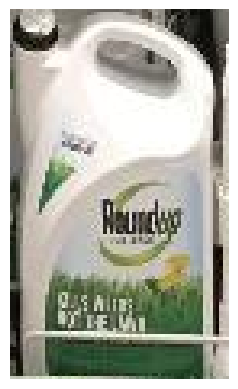

[([[23, 171], [84, 171], [84, 204], [23, 204]], 'Bunt', 0.03941536322236061)]


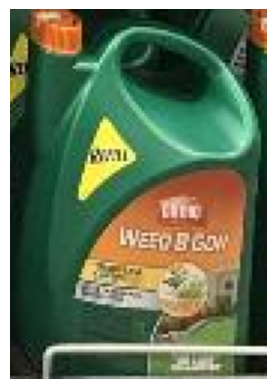

[]


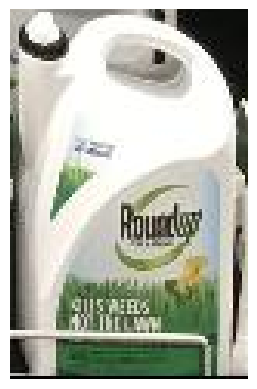

[([[34, 182], [98, 182], [98, 214], [34, 214]], 'S4I6E:', 0.016632915451606858)]


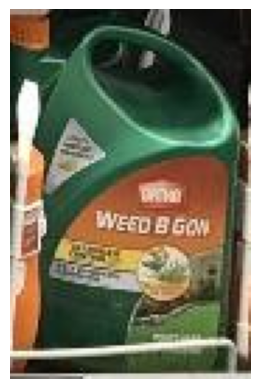

[]


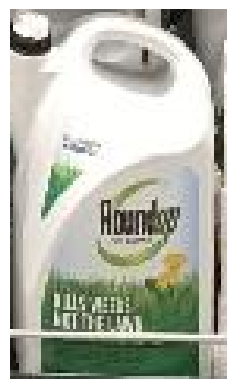

[([[24, 178], [78, 178], [78, 210], [24, 210]], 'Hxath', 0.0404073184086955)]


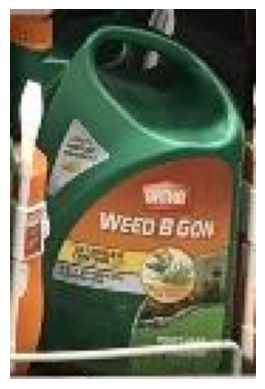

[]


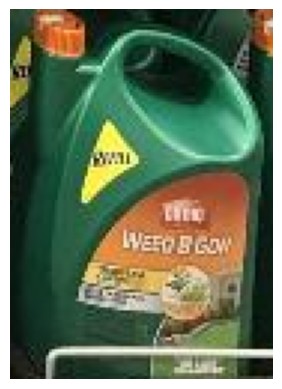

[]


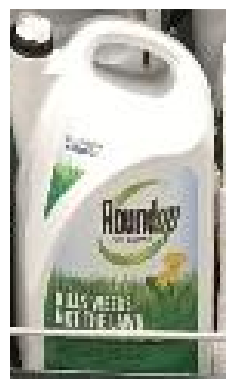

[([[26, 180], [80, 180], [80, 212], [26, 212]], 'Hxath', 0.0404073184086955)]


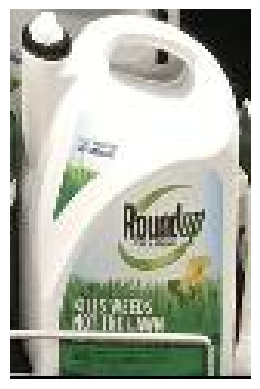

[([[36, 184], [92, 184], [92, 214], [36, 214]], 'M43Ne', 0.0342424674674589)]


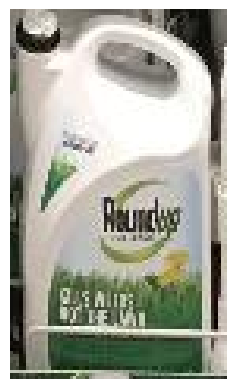

[([[28, 174], [78, 174], [78, 206], [28, 206]], 'Bi', 0.09400624952139566)]


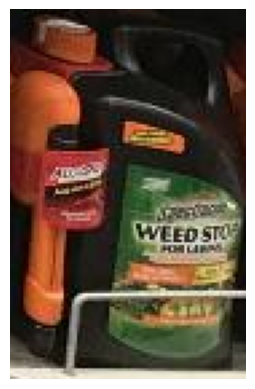

[]


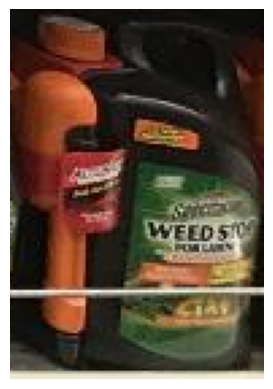

[([[105, 157], [165, 157], [165, 177], [105, 177]], 'EDS', 0.235868668035951)]


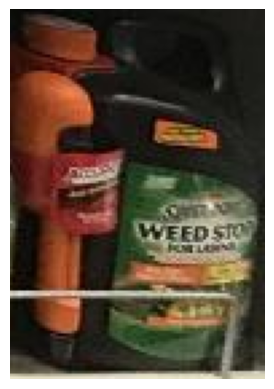

[]


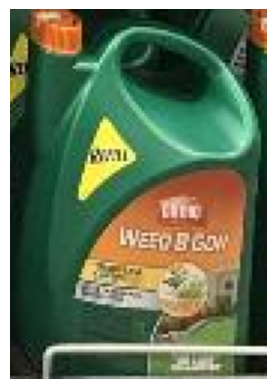

[]


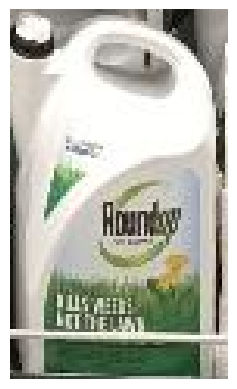

[([[26, 180], [80, 180], [80, 212], [26, 212]], 'Hxath', 0.0404073184086955)]


In [9]:

import imagehash
import os
import matplotlib.pyplot as plt
import io
from PIL import Image
import easyocr
from difflib import SequenceMatcher
import cv2
from PIL import ImageEnhance
from PIL import ImageFilter

# Load the image
image_path = r'C:\Users\kaushal.i.g\Downloads\train_images\train\images\2019_08_02_04_08_39_test7_jpg.rf.b7d46f8c68a70935453ffc70839a1fd4.jpg'
image = Image.open(image_path)

obj_url = r"C:\Users\kaushal.i.g\Downloads\objects\ref_roundup_thin_var.jpg"
total_images = 0
matched_images = 0
def calculate_hash_similarity(window):
    image1 = window
    image2 = Image.open(obj_url)

    
    hash1 = imagehash.average_hash(image1)
    hash2 = imagehash.average_hash(image2)

    
    similarity = 1.0 - (hash1 - hash2) / len(hash1.hash) ** 2

    return similarity

def enhance(image_lr):
    desired_size = (image_lr.size[0] * 2, image_lr.size[1] * 2)  # Increase dimensions by a factor of 2
    
    # Perform bicubic interpolation to increase the resolution
    image_hr = image_lr.resize(desired_size, resample=Image.BICUBIC)
    
    # Display the high-resolution image
    return image_hr

def calculate_rgb_similarity(window):
    image1 = window
    image2 = Image.open(obj_url)

    
    image1 = image1.resize(image2.size)

    
    image1 = image1.convert("RGB")
    image2 = image2.convert("RGB")

    
    histogram1 = image1.histogram()
    histogram2 = image2.histogram()

   
    similarity = sum(min(h1, h2) for h1, h2 in zip(histogram1, histogram2)) / float(sum(histogram1))
    return similarity


# Get the image dimensions


# Iterate over the image pixels with a sliding window
xywh_values = []
labels1 = []
for prediction in results['predictions']:
    x, y, w, h, name= prediction['x'], prediction['y'], prediction['width'], prediction['height'], prediction['class']
    xywh_values.append((x, y, w, h))
    labels1.append(name)
    full_img = cv2.imread(r'C:\Users\kaushal.i.g\Downloads\train_images\train\images\2019_08_02_04_08_39_test7_jpg.rf.b7d46f8c68a70935453ffc70839a1fd4.jpg')
    
    x1 = int(x - w / 2)
    y1 = int(y - h / 2)
    x2 = int(x + w / 2)
    y2 = int(y + h / 2)
        # Extract the window region
        
    window = image.crop((x1, y1, x2, y2))
        

        # Calculate the hash of the window region
    hash_sim = calculate_hash_similarity(window)
    rgb_sim = calculate_rgb_similarity(window)
        

        
    total_images += 1
    img = window
    
    image_gray  = enhance(img)
    image_gray = image_gray.convert('L')
    plt.imshow(window)
    plt.axis('off')  
    plt.show()

        
    threshold = 128 
    image_binary = image_gray.point(lambda p: p > threshold and 255)

        
    image_bytes = io.BytesIO()
    image_binary.save(image_bytes, format='PNG')
    image_bytes = image_bytes.getvalue()
    result = reader.readtext(image_bytes)
    print(result)

      
    text_detected = False
    target_text = "H"
    for text in result:
        if SequenceMatcher(None, target_text, text[1]).ratio() >= 0.5:
            text_detected = True
            break

    

    
            
    if hash_sim >= 0.1 and rgb_sim >= 0.1 and text_detected:   
        matched_images += 1
        plt.imshow(window)
        plt.axis('off')  
        plt.show()
        print(f"matched, hash:{hash_sim:.2%}, rgb:{rgb_sim:.2%}")
        x+=200
            
        
        

        #Images are not clear which is affecting the OCR to detect the text for classification
        

## Classification inception model

In [14]:

import imagehash
import os
import matplotlib.pyplot as plt
import io
from PIL import Image
import easyocr
from difflib import SequenceMatcher
import cv2
from PIL import ImageEnhance
from PIL import ImageFilter
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing import load_image, img_to_array
import numpy as np

# Load the image
image_path = r'C:\Users\kaushal.i.g\Downloads\train_images\train\images\2019_08_02_04_08_39_test7_jpg.rf.b7d46f8c68a70935453ffc70839a1fd4.jpg'
image = Image.open(image_path)

obj_url = r"C:\Users\kaushal.i.g\Downloads\objects\ref_roundup_thin_var.jpg"
total_images = 0
matched_images = 0

def product_vector():
    model = InceptionV3(weights='imagenet', include_top=False, pooling='avg')

    # Load and pre-process the image
    img_path = r'C:\Users\kaushal.i.g\Downloads\objects\ref_roundup_thin_var.jpg'
    img = image.load_img(img_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    # Extract features and flatten
    features = model.predict(x)
    flattened_features = features.flatten()
    
    return flattened_features
    
def window_vector(window):

    # Load and pre-process the image
    
    img = window
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    # Extract features and flatten
    features = model.predict(x)
    flattened_features = features.flatten()


    return flattened_features






# Get the image dimensions


# Iterate over the image pixels with a sliding window
xywh_values = []
labels1 = []
for prediction in results['predictions']:
    x, y, w, h, name= prediction['x'], prediction['y'], prediction['width'], prediction['height'], prediction['class']
    xywh_values.append((x, y, w, h))
    labels1.append(name)
    full_img = cv2.imread(r'C:\Users\kaushal.i.g\Downloads\train_images\train\images\2019_08_02_04_08_39_test7_jpg.rf.b7d46f8c68a70935453ffc70839a1fd4.jpg')
    
    x1 = int(x - w / 2)
    y1 = int(y - h / 2)
    x2 = int(x + w / 2)
    y2 = int(y + h / 2)
        # Extract the window region
        
    window = image.crop((x1, y1, x2, y2))
        

        # Calculate the hash of the window region
    prod = product_vector()
    win = window_vector(window)


    cosine = np.dot(prod,win)/(norm(prod)*norm(win))
    print("Cosine Similarity:", cosine)
            
    # if hash_sim >= 0.1 and rgb_sim >= 0.1 and text_detected:   
    #     matched_images += 1
    #     plt.imshow(window)
    #     plt.axis('off')  
    #     plt.show()
    #     print(f"matched, hash:{hash_sim:.2%}, rgb:{rgb_sim:.2%}")
    #     x+=200
            
        
        

        #Images are not clear which is affecting the OCR to detect the text for classification
        

ImportError: cannot import name 'load_image' from 'tensorflow.keras.preprocessing' (C:\Users\kaushal.i.g\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\api\_v2\keras\preprocessing\__init__.py)

1/1 [==============================] - 3s 3s/step
(2048,)
1/1 [==============================] - 0s 74ms/step


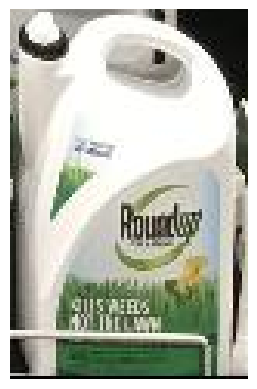

Cosine Similarity: 0.5350581
1/1 [==============================] - 0s 78ms/step


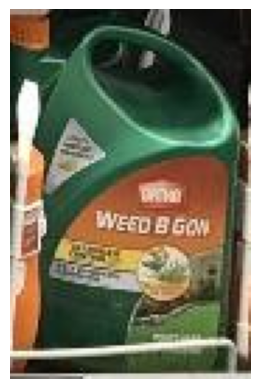

Cosine Similarity: 0.527607
1/1 [==============================] - 0s 73ms/step


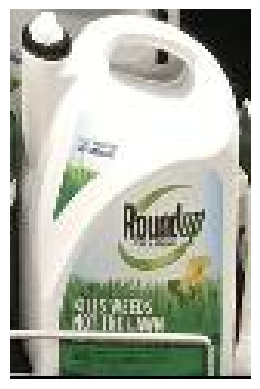

Cosine Similarity: 0.5374199
1/1 [==============================] - 0s 64ms/step


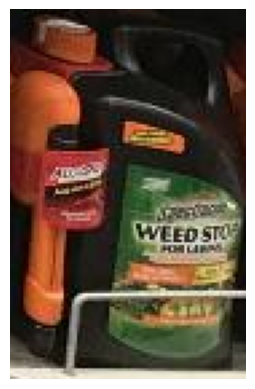

Cosine Similarity: 0.5054196
1/1 [==============================] - 0s 85ms/step


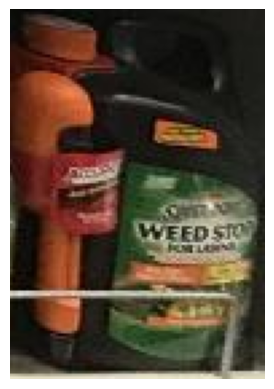

Cosine Similarity: 0.5154847
1/1 [==============================] - 0s 73ms/step


In [24]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import cv2
from numpy.linalg import norm

# Load the Inception V3 model
model = InceptionV3(weights='imagenet', include_top=False, pooling='avg')

# Load and pre-process the image
img_path = r'C:\Users\kaushal.i.g\Downloads\objects\ref_roundup.jpg'
img = load_img(img_path, target_size=(299, 299))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Extract features and flatten
features = model.predict(x)
flattened_features = features.flatten()

print(flattened_features.shape)
A = flattened_features
# Shape of the flattened feature vector

xywh_values = []
labels1 = []
for prediction in results['predictions']:
    x, y, w, h, name= prediction['x'], prediction['y'], prediction['width'], prediction['height'], prediction['class']
    xywh_values.append((x, y, w, h))
    labels1.append(name)
    full_img = cv2.imread(r'C:\Users\kaushal.i.g\Downloads\train_images\train\images\2019_08_02_04_08_39_test7_jpg.rf.b7d46f8c68a70935453ffc70839a1fd4.jpg')
    
    x1 = int(x - w / 2)
    y1 = int(y - h / 2)
    x2 = int(x + w / 2)
    y2 = int(y + h / 2)
        # Extract the window region
        
    window = image.crop((x1, y1, x2, y2))
    img = window
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    # Extract features and flatten
    features = model.predict(x)
    B = features.flatten()
    cosine = np.dot(A,B)/(norm(A)*norm(B))
    if cosine > 0.5:
        plt.imshow(window)
        plt.axis('off')  
        plt.show()
        print("Cosine Similarity:", cosine)


    
    
    

## workspace

In [ ]:
cnn 

Feature extraction (CONV )
Flatten



 Feature Selection ( Dence )

In [35]:
import csv
import os

csv_file = r"C:\Users\kaushal.i.g\Downloads\YOLO_products.v5i.tensorflow\test"

with open(csv_file, "r") as file:
    csv_reader = csv.reader(file)
    next(csv_reader)  # Skip the header row if present
    
    # Iterate over each row in the CSV file
    for row in csv_reader:
        filename, width, height, class_name, xmin, ymin, xmax, ymax = row
        
        # Use the derived class name and other information as needed
        print("Filename:", filename)
        print("Width:", width)
        print("Height:", height)
        print("Class name:", class_name)
        print("Xmin:", xmin)
        print("Ymin:", ymin)
        print("Xmax:", xmax)
        print("Ymax:", ymax)

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\kaushal.i.g\\Downloads\\YOLO_products.v5i.tensorflow\\test'